# Tabular data manipulation with Pandas
Pandas is a Python package that provides several functions for the transformation of tabular data and time series. A good reference book is [*Python for Data Analysis, 3rd Edition*](https://wesmckinney.com/book/) by Wes McKinney. Pandas can handle data of different types. Elements in a column must be of the same type. A table has two axis, vertical, or axis 0 since it is the first index, and horizontal, or axis 1, being the second index. In this notebool we will create synthetic data sampling from the Poisson distribution. The synthetic data will be loaded into a Pandas dataframe and saved in a compressed format. In a second step we will load the data in a new dataframe to apply three different implementations of the linear regression algorithm in order to see their performances.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("Matplotlib version: %s"%mpl.__version__)

Python version: 3.12.5
NumPy version: 1.26.4
Pandas version: 2.2.2
Matplotlib version: 3.8.4


## Process simulation using synthetic data

We will simulate a number of process, e.g. phone usage in number of hours, made by a number or users. We assume the data distributed according to the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). The Poisson discrete distribution is a function defined over integer values from 0 to $+\infty$ that returns a value in the interval [0, 1] and that can represent the number k of occurrences of an event in a time interval

$$f(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

$\lambda$ is the expected number of events per unit time, and k is the number of events. In our simulation a phone user is a data source. We want to simulate $10^5$ persons using the phone a number of hours per day in a time window of 14 days. We use a table of 14 columns, one for each day of the time window, and $10^5$ rows, one for each user (process or data source).

We can easily compute the Poisson distribution from its definition

In [2]:
def poisson(lamda, k):
    result = []
    for i in range(k):
        p = math.exp(-lamda) * (lamda ** i / math.factorial(i))
        result.append(p * lamda)
    return result

In [3]:
lam = 4
k = 14
probabilities = poisson(lam, k)

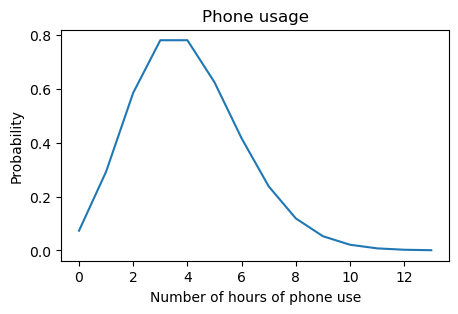

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))
days = np.arange(0, k)
ax.set_title('Phone usage')
ax.set_xlabel('Number of hours of phone use')
ax.set_ylabel('Probability')
ax.plot(days, probabilities)

We cannot use the function that we have defined since we cannot easily sample the Poisson distribution from it, so we will use the implementation available in NumPy.

In [5]:
lam = 60 # expected number of events per unit of time for each user/process, that is hours of phone usage per day per person
NUMBER_OF_DAYS = 14 # number of units of the time window
NUMBER_OF_PEOPLE = 100_000 # number of processes / data sources

We sample 14 values for each user from the Poisson distribution

In [6]:
seed = 100
size = (NUMBER_OF_DAYS, NUMBER_OF_PEOPLE)
random_number_generator = np.random.default_rng() 
hours_per_day_per_person = random_number_generator.poisson(lam=lam, size=size).T / lam

In [7]:
hours_per_day_per_person.mean()

1.0000096428571437

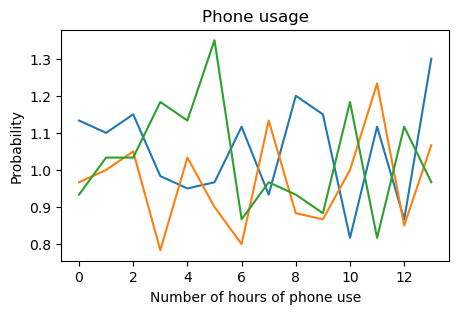

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
days = np.arange(0, 14)
ax.set_title('Phone usage')
ax.set_xlabel('Number of hours of phone use')
ax.set_ylabel('Probability')
ax.plot(days, hours_per_day_per_person[0])
ax.plot(days, hours_per_day_per_person[1000])
ax.plot(days, hours_per_day_per_person[10000])

We load the NumPy array into a Pandas dataframe and then we save the data in a compressed format

In [9]:
outfile = 'generated_ols_data.pickle'
df = pd.DataFrame(hours_per_day_per_person).astype(np.float_)
print(f'Writing {df.shape} to {outfile}')
df.head(3)

Writing (100000, 14) to generated_ols_data.pickle


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.133333,1.1,1.150000,0.983333,0.950000,0.966667,1.116667,0.933333,1.200000,1.150000,0.816667,1.116667,0.866667,1.300000
1,0.833333,0.9,1.016667,1.150000,1.116667,0.966667,1.150000,1.016667,1.050000,0.916667,1.116667,0.950000,1.033333,1.083333
2,1.050000,1.1,1.116667,0.933333,0.966667,1.216667,1.100000,0.916667,1.216667,0.850000,1.250000,0.983333,0.916667,1.150000


In [10]:
df.to_pickle(outfile)

## Linear interpolation
We compute the linear interpolation of the data, that is the coefficient of the interpolating line, for each user using two implementations of the ordinary least squares: the first from sklearn, and the second one from NumPy. An additional variant uses a NumPy array instead of a Pandas series.

In [11]:
def ols_sklearn(row):
    '''
    Solve OLS using scikit-learn's LinearRegression
    Returns the intercept of the interpolating line 
    '''
    est = LinearRegression()
    X = np.arange(row.shape[0]).reshape(-1, 1) # shape (14, 1)
    # note that the intercept is built inside LinearRegression
    est.fit(X, row.values)
    m = est.coef_[0] # note c is in est.intercept_
    return m

In [12]:
def ols_lstsq(row):
    '''
    Solve OLS using numpy.linalg.lstsq
    Returns the intercept of the interpolating line
    '''
    # build X values for [0, 13]
    X = np.arange(row.shape[0]) # shape (14,)
    ones = np.ones(row.shape[0]) # constant used to build intercept
    A = np.vstack((X, ones)).T # shape(14, 2)
    # lstsq returns the coefficient and intercept as the first result
    # followed by the residuals and other items
    m, c = np.linalg.lstsq(A, row.values, rcond=-1)[0]
    return m

In [13]:
def ols_lstsq_raw(row):
    '''
    Variant of `ols_lstsq` where row is a numpy array (not a Series)
    Returns the intercept of the interpolating line
    '''
    X = np.arange(row.shape[0])
    ones = np.ones(row.shape[0])
    A = np.vstack((X, ones)).T
    m, c = np.linalg.lstsq(A, row, rcond=-1)[0]
    return m

In [14]:
df = pd.read_pickle(outfile)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.133333,1.1,1.150000,0.983333,0.950000,0.966667,1.116667,0.933333,1.200000,1.150000,0.816667,1.116667,0.866667,1.300000
1,0.833333,0.9,1.016667,1.150000,1.116667,0.966667,1.150000,1.016667,1.050000,0.916667,1.116667,0.950000,1.033333,1.083333
2,1.050000,1.1,1.116667,0.933333,0.966667,1.216667,1.100000,0.916667,1.216667,0.850000,1.250000,0.983333,0.916667,1.150000


We can apply the algorithms directly in the dataframe to each row (axis=1)

In [15]:
results_ols_lstsq = df.apply(ols_lstsq, axis=1)
print(results_ols_lstsq.shape)
results_ols_lstsq[:5]

(100000,)


0   -0.000769
1    0.006593
2   -0.001026
3   -0.007106
4    0.012821
dtype: float64

## Assessing the algorithms' performance
We compute the average execution time of the algorithms for one user by calling the algorithms e.g. 10000 times. We start by assessing the performance of the sklearn linear interpolation

In [16]:
import timeit
from sklearn.linear_model import LinearRegression
number = 10_000
results = timeit.repeat("ols_sklearn(df.iloc[0])", globals=globals(), number=number)

In [17]:
time_of_fastest = min(results)
print(f"Time to run ols_sklearn for fastest of repeats is {time_of_fastest / number:0.6f} seconds")

Time to run ols_sklearn for fastest of repeats is 0.000894 seconds


Next, we assess the performnce of the NumPy implementation. We can see that the NumPy implementation is faster than sklearn

In [18]:
results = timeit.repeat("ols_lstsq(df.iloc[0])", globals=globals(), number=number)

In [19]:
time_of_fastest = min(results)
print(f"Time to run ols_lstq for fastest of repeats is {time_of_fastest / number:0.6f} seconds")

Time to run ols_lstq for fastest of repeats is 0.000119 seconds


Last, we use the NumPy algorithm with the data as a NumPy array instead of a Pandas Series.

In [20]:
results = timeit.repeat("ols_lstsq_raw(df.iloc[0])", globals=globals(), number=number)

In [21]:
time_of_fastest = min(results)
print(f"Time to run ols_lstq_raw for fastest of repeats is {time_of_fastest / number:0.6f} seconds")

Time to run ols_lstq_raw for fastest of repeats is 0.000187 seconds


## Algorithm profiling
We use the LineProfiler to see which are the bottlenecks of the sklearn linear regression algorithm

In [22]:
from line_profiler import LineProfiler

In [23]:
est = LinearRegression()
row = df.iloc[0]
X = np.arange(row.shape[0]).reshape(-1, 1).astype(np.float_)

In [24]:
lp = LineProfiler(est.fit)
print("Run on a single row")
lp.run("est.fit(X, row.values)")
lp.print_stats()

Run on a single row
Timer unit: 1e-07 s

Total time: 0.0110528 s
File: C:\Users\Luigi\anaconda3\envs\act6-env\Lib\site-packages\sklearn\base.py
Function: _fit_context.<locals>.decorator.<locals>.wrapper at line 1456

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1456                                                   @functools.wraps(fit_method)
  1457                                                   def wrapper(estimator, *args, **kwargs):
  1458         1        238.0    238.0      0.2              global_skip_validation = get_config()["skip_parameter_validation"]
  1459                                           
  1460                                                       # we don't want to validate again for each call to partial_fit
  1461         1         19.0     19.0      0.0              partial_fit_and_fitted = (
  1462         1         44.0     44.0      0.0                  fit_method.__name__ == "partial_fit" and _is_fitted(estimator)
  1463            

In [25]:
from sklearn.linear_model import base
print("Run on 5000 rows")
lp.run("df[:5000].apply(ols_sklearn, axis=1)")
lp.print_stats()

lp = LineProfiler(base._preprocess_data)
lp.run("base._preprocess_data(X, row, fit_intercept=True)")
lp.print_stats()

lp = LineProfiler(base.check_X_y)
lp.run("base.check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'], y_numeric=True, multi_output=True)")
lp.print_stats()


ImportError: cannot import name 'base' from 'sklearn.linear_model' (C:\Users\Luigi\anaconda3\envs\act6-env\Lib\site-packages\sklearn\linear_model\__init__.py)

In [26]:
ms = []
for row_idx, row in df.iterrows():
    m = ols_lstsq(row)
    ms.append(m)
results = pd.Series(ms)

In [27]:
results_ols_lstsq = df.apply(ols_lstsq, axis=1)

In [28]:
df.iloc[0]

0     1.133333
1     1.100000
2     1.150000
3     0.983333
4     0.950000
5     0.966667
6     1.116667
7     0.933333
8     1.200000
9     1.150000
10    0.816667
11    1.116667
12    0.866667
13    1.300000
Name: 0, dtype: float64

In [29]:
df['0_as_str'] = df[0].apply(lambda v: str(v))

In [30]:
def find_9(s):
    '''
    Return -1 if '9' not found else its location at position >= 0
    '''
    return s.split('.')[1].find('9')

In [31]:
df['0_as_str'].str.split('.', expand=True)[1].str.find('9')

0       -1
1       -1
2       -1
3        0
4       -1
        ..
99995    0
99996   -1
99997   -1
99998    0
99999   -1
Name: 1, Length: 100000, dtype: int64

In [32]:
%timeit df['0_as_str'].str.split('.', expand=True)[1].str.find('9')

319 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
